# A. Sourcing & Analyzing Time-Series Data

# 1. Importing libraries and data

Source data: https://data.nasdaq.com/data/BCB/1402-electric-energy-consumption-brazil-commercial

In [49]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles statistical models.
import os
import warnings # This is a library that handles warnings.
import gc

warnings.filterwarnings("ignore") 
plt.style.use('fivethirtyeight')

In [50]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

In [51]:
quandl.ApiConfig.api_key = 'qex1TvFrahazdpDBAx6V'

In [52]:

df = quandl.get('BCB/1402')

In [53]:
df.head()

,Value
Date,
1979-01-31,1038.0
1979-02-28,1030.0
1979-03-31,1057.0
1979-04-30,1044.0
1979-05-31,1038.0


In [54]:
df.tail()

,Value
Date,
2022-05-31,7611.0
2022-06-30,7144.0
2022-07-31,7164.0
2022-08-31,7303.0
2022-09-30,7393.0


#### Data contains monthly details in period 1979-2022

In [55]:
df.shape

(525, 1)

In [56]:
df.columns

Index(['Value'], dtype='object')

In [57]:
type(df)

pandas.core.frame.DataFrame

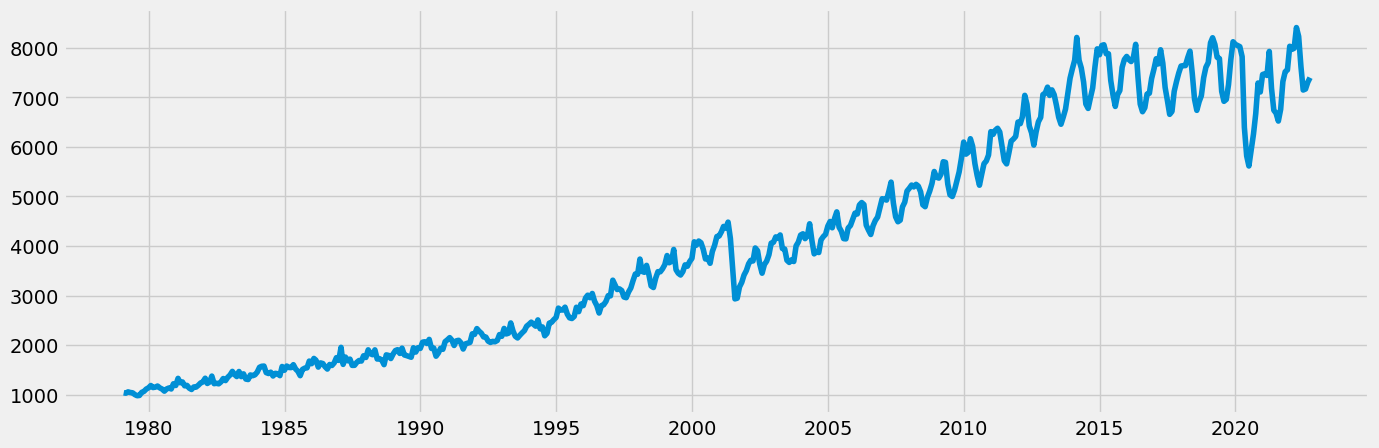

In [58]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(df)

# 2. Subsetting, wrangling, and cleaning time-series data

In [59]:
# Reset index so that you can use the "Date" column as a filter

df_2 = df.reset_index()

In [60]:
df_2.head()

,Date,Value
0,1979-01-31,1038.0
1,1979-02-28,1030.0
2,1979-03-31,1057.0
3,1979-04-30,1044.0
4,1979-05-31,1038.0


In [61]:
df_sub = df_2.loc[(df_2['Date'] >= '2000-01-01')]

In [62]:
df_sub.shape

(273, 2)

In [63]:
# Set the "Date" column as the index

from datetime import datetime

df_sub['datetime'] = pd.to_datetime(df_sub['Date']) # Create a datetime column from "Date.""
df_sub = df_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
df_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
df_sub.head()

,Value
datetime,
2000-01-31,4083.0
2000-02-29,4016.0
2000-03-31,4099.0
2000-04-30,4065.0
2000-05-31,3931.0


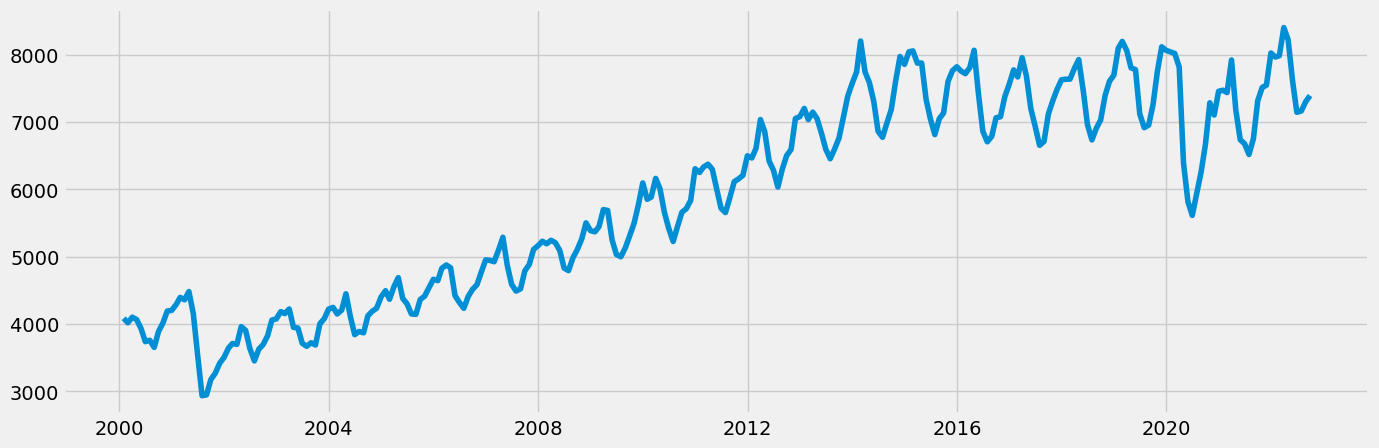

In [64]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(df_sub)

In [65]:
# Check for missing values 

df_sub.isnull().sum() # No missing values

Value    0
dtype: int64

In [66]:
# Check for duplicates

dups = df_sub.duplicated()
dups.sum()

# No dups


8

In [69]:
dups


datetime
2000-01-31    False
2000-02-29    False
2000-03-31    False
2000-04-30    False
2000-05-31    False
              ...  
2022-05-31    False
2022-06-30    False
2022-07-31    False
2022-08-31    False
2022-09-30     True
Length: 273, dtype: bool

# 3.Time-series analysis: decomposition

###  3.1 Decomposition: Additive Model

In [71]:
decomposition_adi = sm.tsa.seasonal_decompose(df_sub, model='additive') 

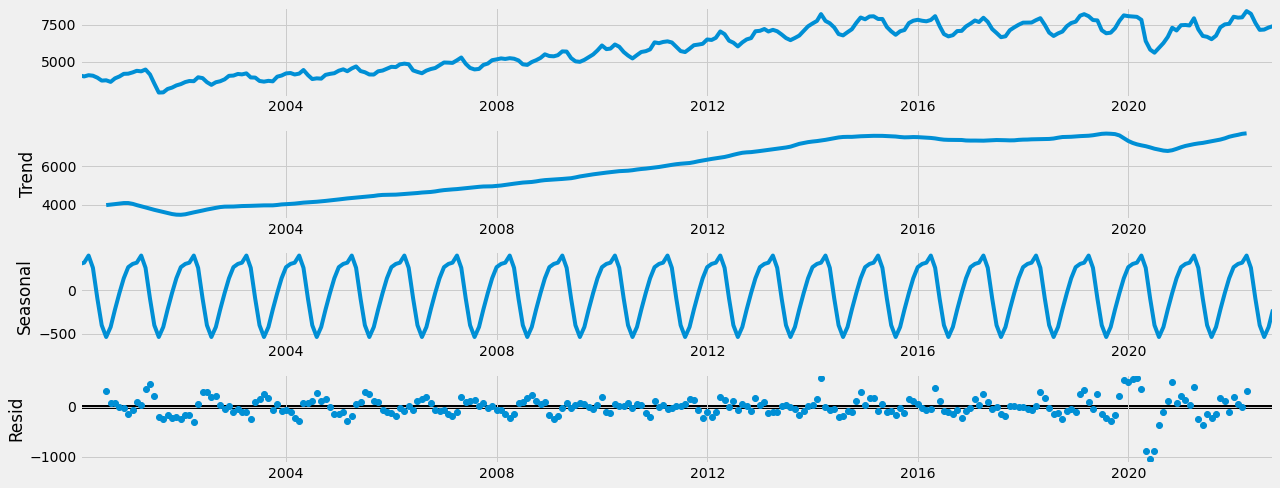

In [72]:
# Plot the separate components

decomposition_adi.plot()
plt.show()

### 3.2 Decomposition: Multiplicative Model

In [73]:
# Decompose the time series using an multiplicative model

decomposition_multi = sm.tsa.seasonal_decompose(df_sub, model='multiplicative') 

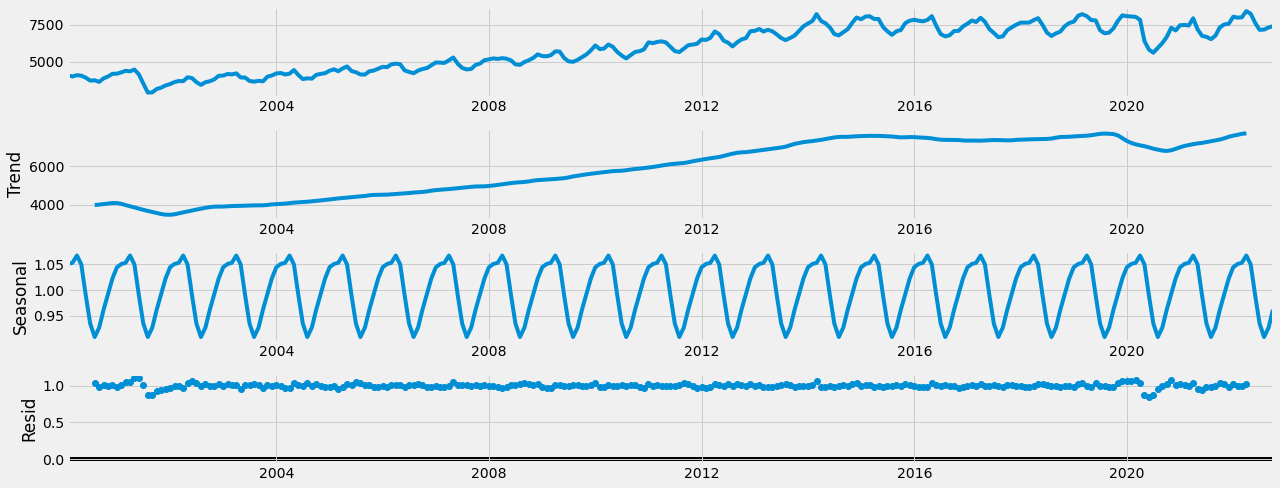

In [74]:
decomposition_multi.plot()
plt.show()

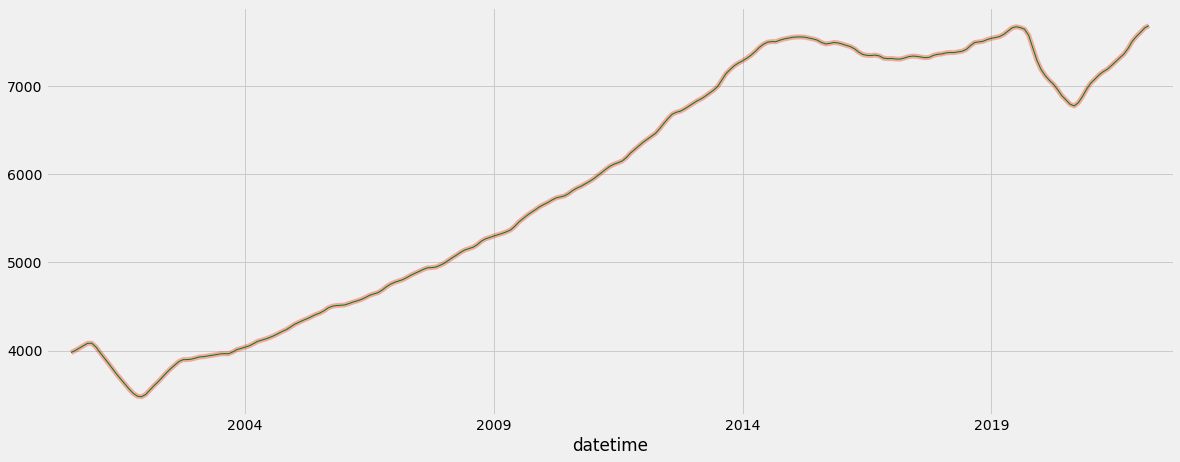

In [75]:
# Evaluating trends component from both models

decomposition_adi.trend.plot(color='red', linewidth=5, alpha=0.3)
decomposition_multi.trend.plot(color='green', linewidth=1)
plt.show()

Looking at the both plots, the additive and multiplicative model exhibits same pattern of trend and seasonality. However, the residual component from additive model has more spread-out spots, compared to the residual component from multiplicative model that has more constant variance. This indicates that a multiplicative model is more appropriate for this time-series

### 4. Testing for stationarity

In [77]:

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(df_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -0.667099
p-value                          0.855088
Number of Lags Used             13.000000
Number of Observations Used    259.000000
Critical Value (1%)             -3.455853
Critical Value (5%)             -2.872765
Critical Value (10%)            -2.572752
dtype: float64


Using significance level of 5%, the critical Value is -2.872765. While, the test statistic is -0.667099, which shows that it is larger than critical value. This means that the null hypothesis cannot be rejected. In other words, there is a unit root in our data and our data is non-stationary.

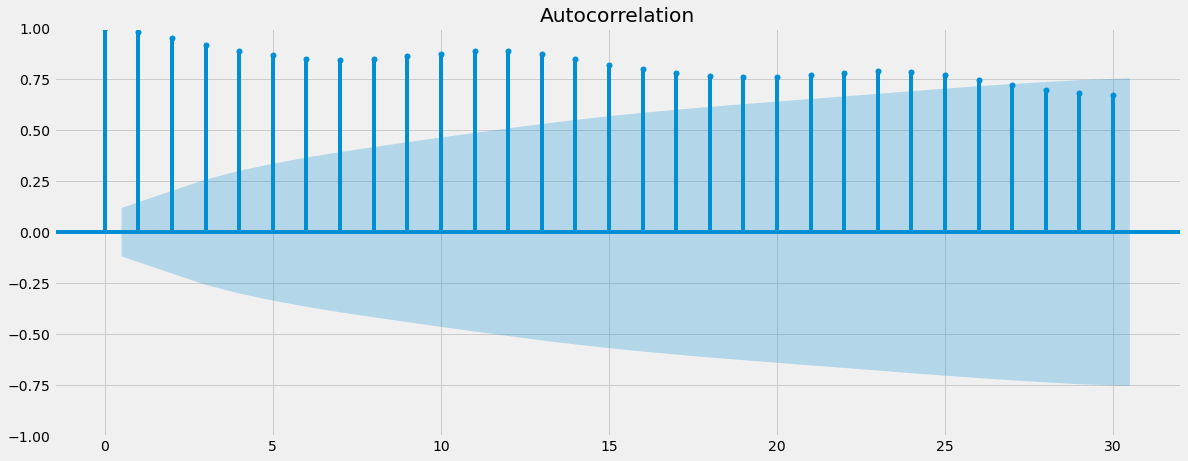

In [78]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import acf, plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(df_sub, lags=30)
plt.show()

In [79]:
autocorr = acf(df_sub, alpha=0.05)

In [80]:
autocorr 

(array([1.        , 0.98046615, 0.94990094, 0.91785937, 0.88828704,
        0.86567663, 0.85055472, 0.84443003, 0.84861432, 0.86090901,
        0.87431053, 0.88680093, 0.88896596, 0.87409639, 0.8491832 ,
        0.82119721, 0.79709161, 0.77985496, 0.76695566, 0.7593343 ,
        0.7607585 , 0.7690637 , 0.7802717 , 0.78841067, 0.78457247]),
 array([[1.        , 1.        ],
        [0.86184373, 1.09908857],
        [0.74710768, 1.1526942 ],
        [0.65994763, 1.17577111],
        [0.58790793, 1.18866615],
        [0.53036544, 1.20098783],
        [0.48514602, 1.21596342],
        [0.45215071, 1.23670935],
        [0.43154064, 1.265688  ],
        [0.4202082 , 1.30160983],
        [0.41054823, 1.33807282],
        [0.40039764, 1.37320423],
        [0.38032078, 1.39761114],
        [0.34403991, 1.40415286],
        [0.29921772, 1.39914869],
        [0.25308105, 1.38931337],
        [0.21251115, 1.38167208],
        [0.18017601, 1.3795339 ],
        [0.15317198, 1.38073933],
        [0.1

The vertical lines represent the lags in the series, while the blue area represents the confidence interval. As we can see, most of lags go above the blue edge of the confidence interval. This means we have lags that are significantly correlated with each other.
In other words, data is non-stationary which supports the result of the Dickey-Fuller test we conducted earlier.

### 5. Stationarizing the Data

In [81]:
df_diff = df_sub - df_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [82]:
df_diff.dropna(inplace = True) 

In [83]:
df_diff.head()

,Value
datetime,
2000-02-29,-67.0
2000-03-31,83.0
2000-04-30,-34.0
2000-05-31,-134.0
2000-06-30,-195.0


In [84]:
df_diff.columns

Index(['Value'], dtype='object')

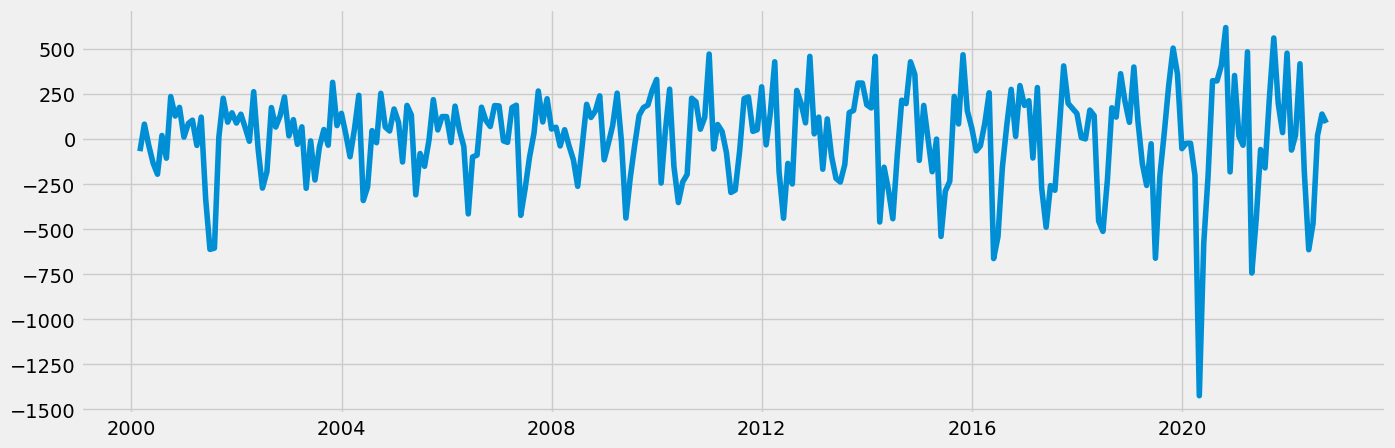

In [85]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_diff)

In [86]:
dickey_fuller(df_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -4.503808
p-value                          0.000194
Number of Lags Used             12.000000
Number of Observations Used    259.000000
Critical Value (1%)             -3.455853
Critical Value (5%)             -2.872765
Critical Value (10%)            -2.572752
dtype: float64


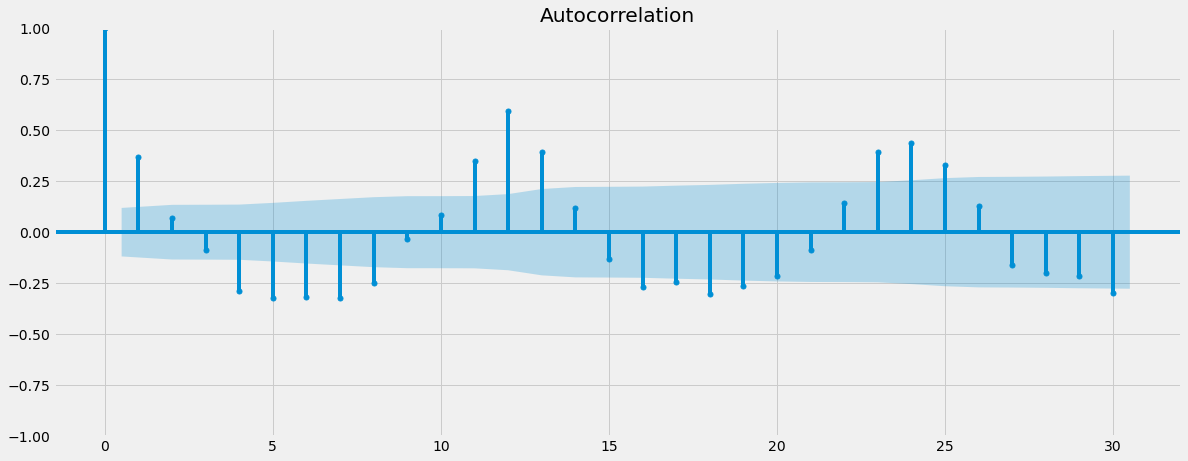

In [87]:
plot_acf(df_diff, lags=30)
plt.show()

### The autocorrelation plot has improved, but the data are still not stationary. As it can be seen, coeffient correlation is positive high at lag 1, 11-13 and 23-25 and negative high at 4-8, 16-19 and 30. From this pattern, we could see that seasonality is present.

#### However, Dickey-Fuller Stationarity test shows that time-series is already stationary.

# B. Time Series Forecasting in Python Bonus

## 1. Defining Parameters

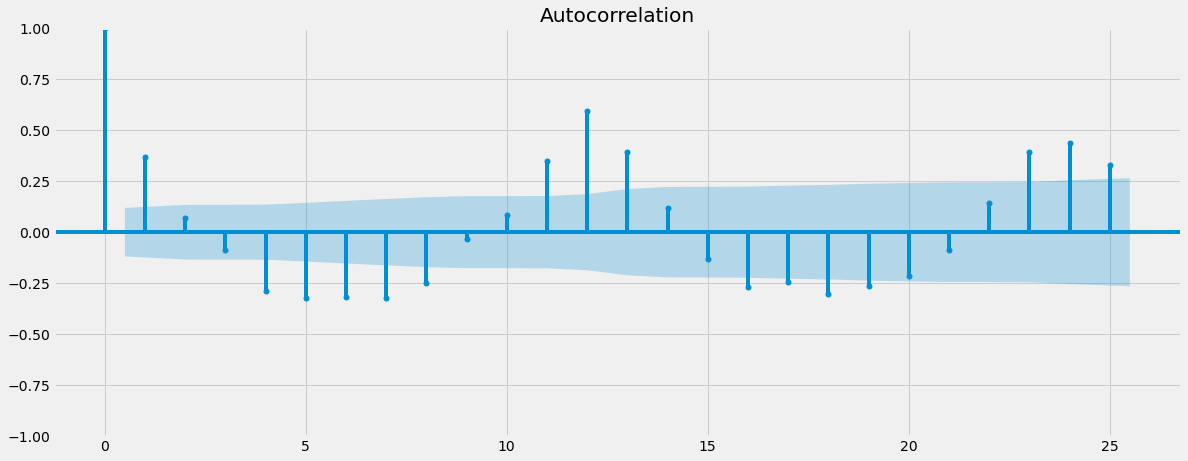

In [88]:
# Plot autocorrelations to determine parameter q

plot_acf(df_diff)
plt.show()

We can see significant ACF group values.(We will take q = 5)

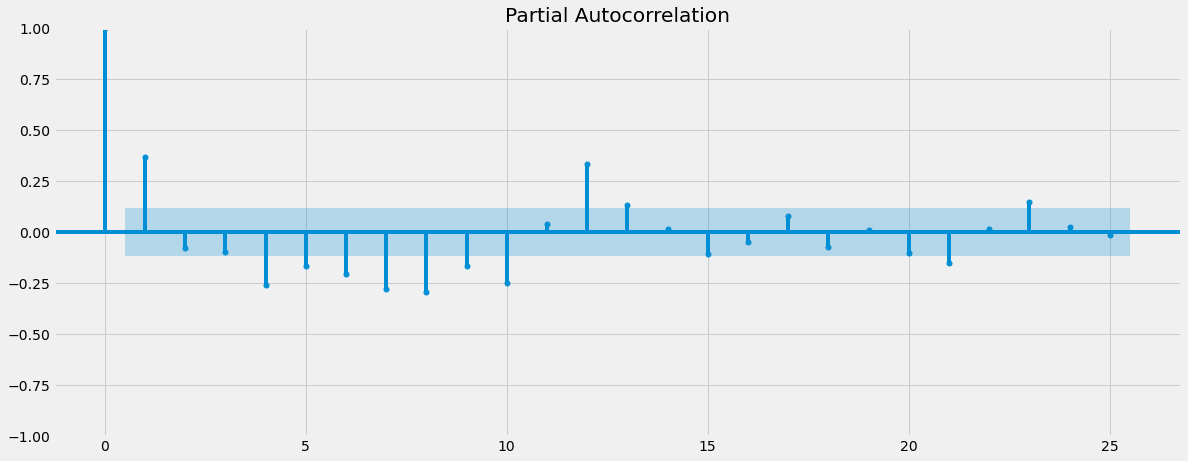

<Figure size 4500x4500 with 0 Axes>

In [89]:
plot_pacf(df_diff)
plt.figure(figsize=(15,15), dpi=300)
plt.show()

We can see 5 significant PACF group values (We will then take p = 5)

### 2. Splitting the Data

In [90]:
train = df_diff[df_diff.index <= '2019-12-31'] 
test = df_diff[df_diff.index >= '2019-12-31']

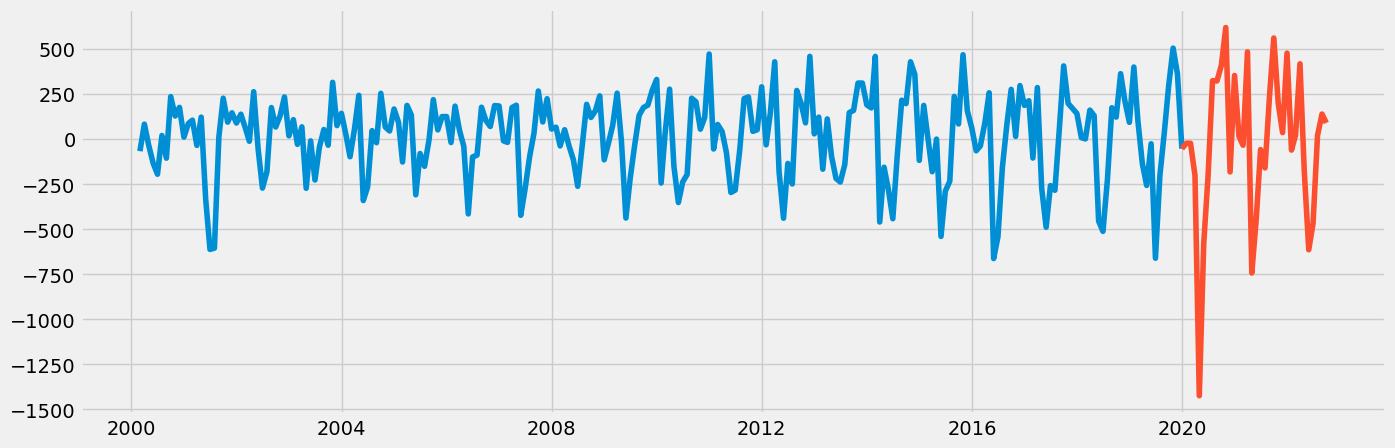

In [91]:
# Plot both sets in order to see the split

plt.figure(figsize=(15,5), dpi=100)
plt.plot(train)
plt.plot(test)

In [93]:
test.shape

(34, 1)

### 3. Running and Fitting the Model

In [94]:
from statsmodels.tsa.api import ARIMA, SARIMAX 

In [95]:
model = ARIMA(train, order=(5, 1, 5))  
fitted = model.fit()  
print(fitted.summary()) # Check model summary

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  239
Model:                 ARIMA(5, 1, 5)   Log Likelihood               -1576.929
Date:                Wed, 16 Nov 2022   AIC                           3175.857
Time:                        17:26:31   BIC                           3214.052
Sample:                    02-29-2000   HQIC                          3191.251
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5141      0.193      2.661      0.008       0.135       0.893
ar.L2         -0.0139      0.055     -0.254      0.800      -0.121       0.094
ar.L3          0.6620      0.029     23.191      0.0

In [96]:
# Forecast
fc = fitted.get_forecast(33, alpha=0.05)  # 95% confidence interval  --> alpha = 0.05; 33 is the shape of the test set

# Make into pandas series
fc_series = pd.Series(fc.predicted_mean, index=test.index)
lower_series = pd.Series(fc.conf_int().iloc[:, 0], index=test.index)
upper_series = pd.Series(fc.conf_int().iloc[:, 1], index=test.index)

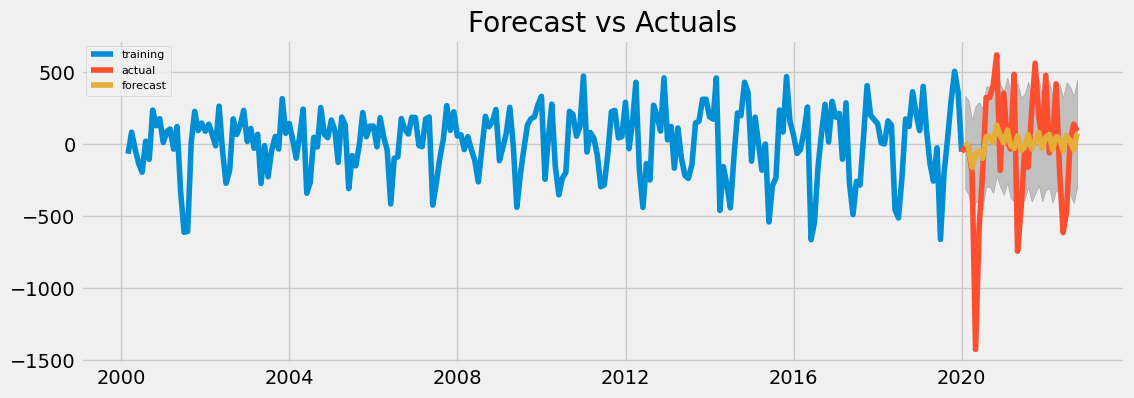

In [97]:
# Plot
plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.2)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### 4. Iterating

### 4.1  Iteration ARIMA(8, 1, 0)


In [98]:
model = ARIMA(train, order=(8, 1, 0))  
fitted = model.fit()  
print(fitted.summary()) # Check model summary

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  239
Model:                 ARIMA(8, 1, 0)   Log Likelihood               -1621.590
Date:                Wed, 16 Nov 2022   AIC                           3261.179
Time:                        17:30:25   BIC                           3292.429
Sample:                    02-29-2000   HQIC                          3273.774
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4349      0.065     -6.689      0.000      -0.562      -0.307
ar.L2         -0.3530      0.081     -4.380      0.000      -0.511      -0.195
ar.L3         -0.3149      0.073     -4.323      0.0

In [101]:
# Forecast
fc = fitted.get_forecast(33, alpha=0.05)  # 95% confidence interval  --> alpha = 0.05; 33 is the shape of the test set

# Make into pandas series
fc_series = pd.Series(fc.predicted_mean, index=test.index)
lower_series = pd.Series(fc.conf_int().iloc[:, 0], index=test.index)
upper_series = pd.Series(fc.conf_int().iloc[:, 1], index=test.index)

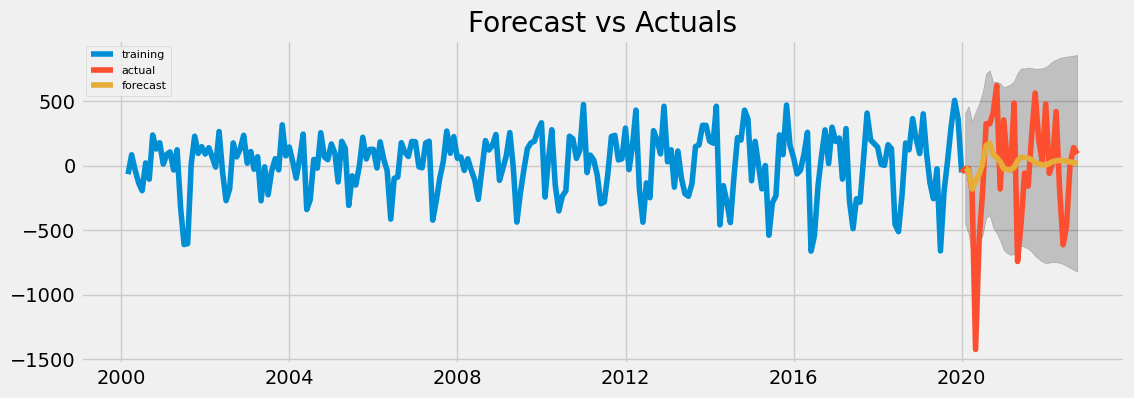

In [102]:
# Plot
plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.2)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### 4.2 Try Seasonal-ARIMA

In [103]:
mod = sm.tsa.SARIMAX(train, order=(1,0,0), seasonal_order=(0,1,1,12))
fitted = mod.fit()
print(fitted.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Value   No. Observations:                  239
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood               -1465.948
Date:                              Wed, 16 Nov 2022   AIC                           2937.896
Time:                                      17:52:23   BIC                           2948.171
Sample:                                  02-29-2000   HQIC                          2942.042
                                       - 12-31-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1830      0.049     -3.739      0.000      -0.279      -0.087
ma.S.L12      -0.77

In [104]:
# Forecast
fc = fitted.get_forecast(33, alpha=0.05)  # 95% confidence interval  --> alpha = 0.05; 33 is the shape of the test set

# Make into pandas series
fc_series = pd.Series(fc.predicted_mean, index=test.index)
lower_series = pd.Series(fc.conf_int().iloc[:, 0], index=test.index)
upper_series = pd.Series(fc.conf_int().iloc[:, 1], index=test.index)

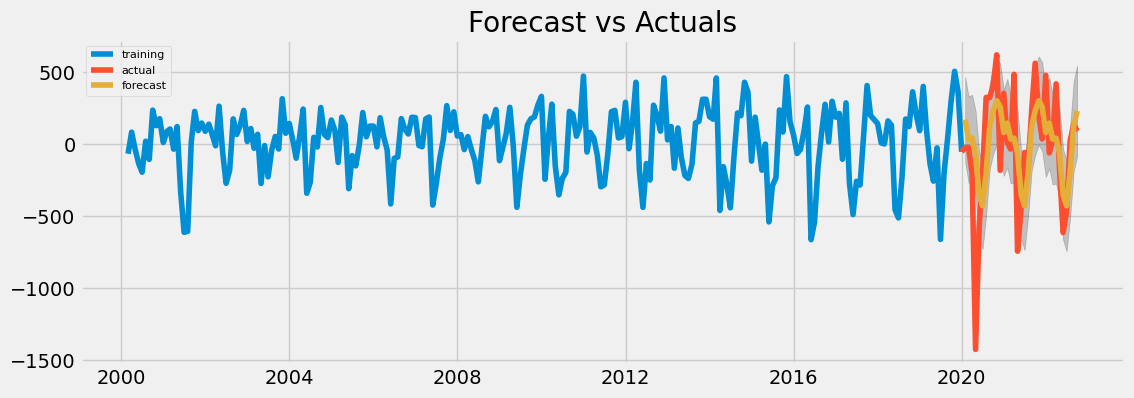

In [105]:
# Plot
plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.2)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [106]:
gc.collect()

48385